In [ ]:
import albumentations as A
import cv2
import os
import random
from tqdm import tqdm

# Define a strong augmentation pipeline
augmentations = A.Compose([
    A.RandomBrightnessContrast(p=0.5),
    A.Rotate(limit=30, p=0.7),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.RandomGamma(p=0.3),
    A.GaussNoise(p=0.2),
    A.Blur(blur_limit=3, p=0.2)
])


In [17]:
# Path to dataset
base_dir = r'D:\archive_split\train'  # e.g., "./data/train"
target_count = 400  # Number of images you want per class after augmentation
img_size = (128,128) # Adjust to your model input size


In [19]:
def augment_class_images(class_path, class_name):
    images = os.listdir(class_path)
    current_count = len(images)

    if current_count >= target_count:
        print(f"[SKIP] {class_name}: Already has {current_count} images.")
        return

    print(f"[AUGMENT] {class_name}: Found {current_count}, augmenting to {target_count}.")

    while len(os.listdir(class_path)) < target_count:
        img_file = random.choice(images)
        img_path = os.path.join(class_path, img_file)
        image = cv2.imread(img_path)
        if image is None:
            continue

        # Resize before augmenting
        image = cv2.resize(image, img_size)

        # Apply augmentation
        augmented = augmentations(image=image)
        aug_image = augmented['image']

        # Save augmented image
        aug_filename = f"{class_name}_aug_{random.randint(10000, 99999)}.jpg"
        aug_path = os.path.join(class_path, aug_filename)
        cv2.imwrite(aug_path, aug_image)

# Loop through all class folders
for class_name in os.listdir(base_dir):
    class_path = os.path.join(base_dir, class_name)
    if os.path.isdir(class_path):
        augment_class_images(class_path, class_name)


[SKIP] Broken stitch: Already has 400 images.
[SKIP] defect free: Already has 1666 images.
[SKIP] hole: Already has 400 images.
[SKIP] horizontal: Already has 400 images.
[SKIP] lines: Already has 400 images.
[SKIP] Needle mark: Already has 400 images.
[SKIP] Pinched fabric: Already has 400 images.
[SKIP] stain: Already has 400 images.
[SKIP] Vertical: Already has 400 images.


In [21]:
import os

dataset_path = r'D:\archive_split\train'
for class_name in sorted(os.listdir(dataset_path)):
    class_dir = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_dir):
        count = len([f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))])
        print(f"{class_name}: {count} images")


Broken stitch: 400 images
Needle mark: 400 images
Pinched fabric: 400 images
Vertical: 400 images
defect free: 1666 images
hole: 400 images
horizontal: 400 images
lines: 400 images
stain: 400 images


In [27]:
import json

# Load the COCO annotation file
with open(ANNOTATION_PATH, 'r') as f:
    coco = json.load(f)

# Check top-level keys to verify it's loaded
print("COCO keys:", coco.keys())


COCO keys: dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])


In [29]:
import os
import json
import shutil
from tqdm import tqdm

# Update this path
ANNOTATION_PATH = r"D:\TILDA Fabric.v2-tilda-v2.coco\train\_annotations.coco.json"
IMAGES_DIR = os.path.dirname(ANNOTATION_PATH)
OUTPUT_DIR = r"D:\fabric_dataset_split"

# Create output folders
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Load COCO JSON
with open(ANNOTATION_PATH, 'r') as f:
    coco = json.load(f)

# Build lookup dictionaries
id_to_filename = {img['id']: img['file_name'] for img in coco['images']}
categories = {cat['id']: cat['name'].replace(" ", "_") for cat in coco['categories']}

# Create category folders
for class_name in categories.values():
    os.makedirs(os.path.join(OUTPUT_DIR, class_name), exist_ok=True)

# Track number of images processed
count = 0

# Process annotations
for ann in tqdm(coco['annotations']):
    img_id = ann['image_id']
    class_id = ann['category_id']
    class_name = categories[class_id]
    file_name = id_to_filename[img_id]
    
    src_path = os.path.join(IMAGES_DIR, file_name)
    dst_path = os.path.join(OUTPUT_DIR, class_name, file_name)

    if os.path.exists(src_path):
        shutil.copy(src_path, dst_path)
        count += 1

print(f"✅ Copied {count} images into class folders at: {OUTPUT_DIR}")


100%|██████████| 926/926 [00:06<00:00, 143.41it/s]

✅ Copied 926 images into class folders at: D:\fabric_dataset_split


In [37]:
import os
import shutil
import random
from tqdm import tqdm

# Set seed for reproducibility
random.seed(42)

# Kaggle dataset base folders
kaggle_base = r"D:\archive_split"
kaggle_train = os.path.join(kaggle_base, "train")
kaggle_val = os.path.join(kaggle_base, "validation")
kaggle_test = os.path.join(kaggle_base, "test")

# TILDA converted classification dataset
tilda_dir = r"D:\fabric_dataset_split"

# Split percentages for TILDA data
split_ratios = {
    "train": 0.8,
    "validation": 0.1,
    "test": 0.1
}

# Function to copy with rename if needed
def safe_copy(src_path, dst_dir):
    if not os.path.isfile(src_path):
        return  # skip directories
    filename = os.path.basename(src_path)
    dst_path = os.path.join(dst_dir, filename)
    if not os.path.exists(dst_path):
        shutil.copy(src_path, dst_path)
    else:
        base, ext = os.path.splitext(filename)
        count = 1
        while os.path.exists(os.path.join(dst_dir, f"{base}_{count}{ext}")):
            count += 1
        shutil.copy(src_path, os.path.join(dst_dir, f"{base}_{count}{ext}"))

# Merge TILDA images into Kaggle train/val/test
for class_name in os.listdir(tilda_dir):
    class_path = os.path.join(tilda_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
    random.shuffle(images)
    n_total = len(images)
    n_train = int(split_ratios['train'] * n_total)
    n_val = int(split_ratios['validation'] * n_total)

    splits = {
        kaggle_train: images[:n_train],
        kaggle_val: images[n_train:n_train + n_val],
        kaggle_test: images[n_train + n_val:]
    }

    for split_dir, split_files in splits.items():
        class_dst = os.path.join(split_dir, class_name)
        os.makedirs(class_dst, exist_ok=True)

        for fname in tqdm(split_files, desc=f"Merging {class_name} into {os.path.basename(split_dir)}"):
            src = os.path.join(class_path, fname)
            safe_copy(src, class_dst)

print("\n✅ TILDA dataset successfully merged into Kaggle splits at D:/archive_split")


Merging Fabric into train: 0it [00:00, ?it/s]
Merging Fabric into validation: 0it [00:00, ?it/s]
Merging Fabric into test: 0it [00:00, ?it/s]
Merging oil_spot into test: 100%|██████████| 19/19 [00:00<00:00, 2715.04it/s]
Merging test into train: 0it [00:00, ?it/s]
Merging test into validation: 0it [00:00, ?it/s]
Merging test into test: 0it [00:00, ?it/s]
Merging thread_error into test: 100%|██████████| 20/20 [00:00<00:00, 79.67it/s]
Merging train into train: 0it [00:00, ?it/s]
Merging train into validation: 0it [00:00, ?it/s]
Merging train into test: 0it [00:00, ?it/s]
Merging validation into train: 0it [00:00, ?it/s]
Merging validation into validation: 0it [00:00, ?it/s]
Merging validation into test: 0it [00:00, ?it/s]


✅ TILDA dataset successfully merged into Kaggle splits at D:/archive_split


In [1]:
# importing necessary libraries........
import os
import shutil
import random
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3, MobileNetV2
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:

# Custom SparseCategoricalFocalLoss implementation
class SparseCategoricalFocalLoss(tf.keras.losses.Loss):
    def __init__(self, gamma=2.0, alpha=0.25, **kwargs):
        super().__init__(**kwargs)
        self.gamma = gamma
        self.alpha = alpha

    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        y_true = tf.one_hot(y_true, depth=tf.shape(y_pred)[-1])
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1. - 1e-7)
        cross_entropy = -y_true * tf.math.log(y_pred)
        weights = self.alpha * tf.math.pow(1 - y_pred, self.gamma)
        return tf.reduce_mean(tf.reduce_sum(weights * cross_entropy, axis=-1))


In [5]:
# Paths
DATA_DIR = r"D:/archive_split"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
VAL_DIR = os.path.join(DATA_DIR, "validation")
TEST_DIR = os.path.join(DATA_DIR, "test")
IMG_SIZE = 128
BATCH_SIZE = 32
EPOCHS = 30
MODEL_PATH = "best_fabric_model.h5"


In [7]:
# Classes
classes = sorted(os.listdir(TRAIN_DIR))
num_classes = len(classes)
class_indices = {cls: i for i, cls in enumerate(classes)}


In [9]:
# Data generators
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(TRAIN_DIR,
                                              target_size=(IMG_SIZE, IMG_SIZE),
                                              batch_size=BATCH_SIZE,
                                              class_mode='sparse')
val_gen = val_datagen.flow_from_directory(VAL_DIR,
                                          target_size=(IMG_SIZE, IMG_SIZE),
                                          batch_size=BATCH_SIZE,
                                          class_mode='sparse')

Found 6419 images belonging to 16 classes.
Found 2935 images belonging to 16 classes.


In [11]:
# Compute class weights
labels = train_gen.classes
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights_dict = dict(enumerate(class_weights))


In [13]:
# Dual backbone
input_tensor = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

base1 = EfficientNetB3(include_top=False, input_tensor=input_tensor, weights='imagenet')
base2 = MobileNetV2(include_top=False, input_tensor=input_tensor, weights='imagenet')

x1 = base1.output
x1 = GlobalAveragePooling2D()(x1)

x2 = base2.output
x2 = GlobalAveragePooling2D()(x2)

merged = Concatenate()([x1, x2])
out = Dense(num_classes, activation='softmax')(merged)

model = Model(inputs=input_tensor, outputs=out)


C:\Users\raman\AppData\Local\Temp\ipykernel_20264\3704787246.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base2 = MobileNetV2(include_top=False, input_tensor=input_tensor, weights='imagenet')


In [15]:
# Compile
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-4),
              loss=SparseCategoricalFocalLoss(gamma=2),
              metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 128, 128,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 128, 128,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 128, 128,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 129, 129,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 64, 64,    │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 64, 64,    │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 64, 64,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 64, 64,    │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 64, 64,    │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 64, 64,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 64, 64,    │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 64, 64,    │        960 │ block1a_se_excit

 Total params: 13,086,591 (49.92 MB)

 Trainable params: 12,965,176 (49.46 MB)

 Non-trainable params: 121,415 (474.28 KB)

In [17]:
# Callbacks
callbacks = [
    ModelCheckpoint(MODEL_PATH, monitor='val_accuracy', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, verbose=1)
]

In [19]:
# Train
history = model.fit(train_gen,
                    epochs=EPOCHS,
                    validation_data=val_gen,
                    class_weight=class_weights_dict,
                    callbacks=callbacks)

C:\Users\raman\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5642 - loss: 0.2919
Epoch 1: val_accuracy improved from -inf to 0.18058, saving model to best_fabric_model.h5


201/201 ━━━━━━━━━━━━━━━━━━━━ 893s 4s/step - accuracy: 0.5648 - loss: 0.2913 - val_accuracy: 0.1806 - val_loss: 0.4607 - learning_rate: 1.0000e-04
Epoch 2/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8081 - loss: 0.0729
Epoch 2: val_accuracy improved from 0.18058 to 0.67189, saving model to best_fabric_model.h5


201/201 ━━━━━━━━━━━━━━━━━━━━ 713s 4s/step - accuracy: 0.8082 - loss: 0.0728 - val_accuracy: 0.6719 - val_loss: 0.2091 - learning_rate: 1.0000e-04
Epoch 3/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8529 - loss: 0.0534
Epoch 3: val_accuracy did not improve from 0.67189
201/201 ━━━━━━━━━━━━━━━━━━━━ 722s 4s/step - accuracy: 0.8530 - loss: 0.0534 - val_accuracy: 0.6140 - val_loss: 0.1972 - learning_rate: 1.0000e-04
Epoch 4/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8766 - loss: 0.0431
Epoch 4: val_accuracy improved from 0.67189 to 0.72232, saving model to best_fabric_model.h5


201/201 ━━━━━━━━━━━━━━━━━━━━ 730s 4s/step - accuracy: 0.8767 - loss: 0.0431 - val_accuracy: 0.7223 - val_loss: 0.1250 - learning_rate: 1.0000e-04
Epoch 5/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8923 - loss: 0.0338
Epoch 5: val_accuracy improved from 0.72232 to 0.80068, saving model to best_fabric_model.h5


201/201 ━━━━━━━━━━━━━━━━━━━━ 732s 4s/step - accuracy: 0.8923 - loss: 0.0338 - val_accuracy: 0.8007 - val_loss: 0.0781 - learning_rate: 1.0000e-04
Epoch 6/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9168 - loss: 0.0279
Epoch 6: val_accuracy improved from 0.80068 to 0.80170, saving model to best_fabric_model.h5


201/201 ━━━━━━━━━━━━━━━━━━━━ 738s 4s/step - accuracy: 0.9168 - loss: 0.0279 - val_accuracy: 0.8017 - val_loss: 0.0841 - learning_rate: 1.0000e-04
Epoch 7/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9220 - loss: 0.0265
Epoch 7: val_accuracy improved from 0.80170 to 0.85997, saving model to best_fabric_model.h5


201/201 ━━━━━━━━━━━━━━━━━━━━ 733s 4s/step - accuracy: 0.9220 - loss: 0.0266 - val_accuracy: 0.8600 - val_loss: 0.0479 - learning_rate: 1.0000e-04
Epoch 8/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9341 - loss: 0.0205
Epoch 8: val_accuracy did not improve from 0.85997
201/201 ━━━━━━━━━━━━━━━━━━━━ 745s 4s/step - accuracy: 0.9341 - loss: 0.0205 - val_accuracy: 0.8269 - val_loss: 0.0826 - learning_rate: 1.0000e-04
Epoch 9/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.9283 - loss: 0.0229
Epoch 9: val_accuracy did not improve from 0.85997
201/201 ━━━━━━━━━━━━━━━━━━━━ 2210s 11s/step - accuracy: 0.9283 - loss: 0.0229 - val_accuracy: 0.7731 - val_loss: 0.1055 - learning_rate: 1.0000e-04
Epoch 10/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9287 - loss: 0.0222
Epoch 10: val_accuracy did not improve from 0.85997

Epoch 10: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
201/201 ━━━━━━━━━━━━━━━━━━━━ 2002s 10s/step - accuracy: 0.9287 - loss: 

201/201 ━━━━━━━━━━━━━━━━━━━━ 902s 4s/step - accuracy: 0.9502 - loss: 0.0138 - val_accuracy: 0.9264 - val_loss: 0.0223 - learning_rate: 5.0000e-05
Epoch 12/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9551 - loss: 0.0133
Epoch 12: val_accuracy did not improve from 0.92641
201/201 ━━━━━━━━━━━━━━━━━━━━ 747s 4s/step - accuracy: 0.9551 - loss: 0.0132 - val_accuracy: 0.9257 - val_loss: 0.0197 - learning_rate: 5.0000e-05
Epoch 13/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9601 - loss: 0.0117
Epoch 13: val_accuracy improved from 0.92641 to 0.92675, saving model to best_fabric_model.h5


201/201 ━━━━━━━━━━━━━━━━━━━━ 788s 4s/step - accuracy: 0.9601 - loss: 0.0117 - val_accuracy: 0.9267 - val_loss: 0.0188 - learning_rate: 5.0000e-05
Epoch 14/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9629 - loss: 0.0108
Epoch 14: val_accuracy improved from 0.92675 to 0.96763, saving model to best_fabric_model.h5


201/201 ━━━━━━━━━━━━━━━━━━━━ 751s 4s/step - accuracy: 0.9629 - loss: 0.0108 - val_accuracy: 0.9676 - val_loss: 0.0071 - learning_rate: 5.0000e-05
Epoch 15/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9607 - loss: 0.0109
Epoch 15: val_accuracy did not improve from 0.96763
201/201 ━━━━━━━━━━━━━━━━━━━━ 771s 4s/step - accuracy: 0.9607 - loss: 0.0109 - val_accuracy: 0.9322 - val_loss: 0.0189 - learning_rate: 5.0000e-05
Epoch 16/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9638 - loss: 0.0099
Epoch 16: val_accuracy did not improve from 0.96763
201/201 ━━━━━━━━━━━━━━━━━━━━ 771s 4s/step - accuracy: 0.9638 - loss: 0.0099 - val_accuracy: 0.9530 - val_loss: 0.0138 - learning_rate: 5.0000e-05
Epoch 17/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9698 - loss: 0.0089
Epoch 17: val_accuracy did not improve from 0.96763

Epoch 17: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
201/201 ━━━━━━━━━━━━━━━━━━━━ 766s 4s/step - accuracy: 0.9698 - loss: 0

201/201 ━━━━━━━━━━━━━━━━━━━━ 784s 4s/step - accuracy: 0.9714 - loss: 0.0084 - val_accuracy: 0.9782 - val_loss: 0.0048 - learning_rate: 2.5000e-05
Epoch 19/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9717 - loss: 0.0074
Epoch 19: val_accuracy improved from 0.97819 to 0.98194, saving model to best_fabric_model.h5


201/201 ━━━━━━━━━━━━━━━━━━━━ 780s 4s/step - accuracy: 0.9717 - loss: 0.0074 - val_accuracy: 0.9819 - val_loss: 0.0040 - learning_rate: 2.5000e-05
Epoch 20/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9771 - loss: 0.0066
Epoch 20: val_accuracy did not improve from 0.98194
201/201 ━━━━━━━━━━━━━━━━━━━━ 803s 4s/step - accuracy: 0.9770 - loss: 0.0066 - val_accuracy: 0.9792 - val_loss: 0.0046 - learning_rate: 2.5000e-05
Epoch 21/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9779 - loss: 0.0062
Epoch 21: val_accuracy did not improve from 0.98194
201/201 ━━━━━━━━━━━━━━━━━━━━ 794s 4s/step - accuracy: 0.9778 - loss: 0.0062 - val_accuracy: 0.9629 - val_loss: 0.0084 - learning_rate: 2.5000e-05
Epoch 22/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9784 - loss: 0.0061
Epoch 22: val_accuracy did not improve from 0.98194

Epoch 22: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
201/201 ━━━━━━━━━━━━━━━━━━━━ 809s 4s/step - accuracy: 0.9784 - loss: 0

201/201 ━━━━━━━━━━━━━━━━━━━━ 860s 4s/step - accuracy: 0.9767 - loss: 0.0064 - val_accuracy: 0.9922 - val_loss: 0.0018 - learning_rate: 1.2500e-05
Epoch 24/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9780 - loss: 0.0053
Epoch 24: val_accuracy did not improve from 0.99216
201/201 ━━━━━━━━━━━━━━━━━━━━ 842s 4s/step - accuracy: 0.9780 - loss: 0.0053 - val_accuracy: 0.9908 - val_loss: 0.0020 - learning_rate: 1.2500e-05
Epoch 25/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9772 - loss: 0.0057
Epoch 25: val_accuracy did not improve from 0.99216
201/201 ━━━━━━━━━━━━━━━━━━━━ 782s 4s/step - accuracy: 0.9772 - loss: 0.0057 - val_accuracy: 0.9853 - val_loss: 0.0031 - learning_rate: 1.2500e-05
Epoch 26/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9809 - loss: 0.0052
Epoch 26: val_accuracy did not improve from 0.99216

Epoch 26: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
201/201 ━━━━━━━━━━━━━━━━━━━━ 800s 4s/step - accuracy: 0.9809 - loss: 0.

201/201 ━━━━━━━━━━━━━━━━━━━━ 784s 4s/step - accuracy: 0.9789 - loss: 0.0054 - val_accuracy: 0.9928 - val_loss: 0.0015 - learning_rate: 6.2500e-06
Epoch 28/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9827 - loss: 0.0051
Epoch 28: val_accuracy improved from 0.99284 to 0.99387, saving model to best_fabric_model.h5


201/201 ━━━━━━━━━━━━━━━━━━━━ 795s 4s/step - accuracy: 0.9827 - loss: 0.0051 - val_accuracy: 0.9939 - val_loss: 0.0014 - learning_rate: 6.2500e-06
Epoch 29/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9831 - loss: 0.0047
Epoch 29: val_accuracy did not improve from 0.99387
201/201 ━━━━━━━━━━━━━━━━━━━━ 1057s 5s/step - accuracy: 0.9831 - loss: 0.0047 - val_accuracy: 0.9922 - val_loss: 0.0016 - learning_rate: 6.2500e-06
Epoch 30/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.9819 - loss: 0.0046
Epoch 30: val_accuracy did not improve from 0.99387
201/201 ━━━━━━━━━━━━━━━━━━━━ 2208s 11s/step - accuracy: 0.9819 - loss: 0.0046 - val_accuracy: 0.9918 - val_loss: 0.0014 - learning_rate: 6.2500e-06


In [38]:
test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    r"D:/archive_split/test",
    target_size=(128, 128),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)
test_loss, test_accuracy = model.evaluate(test_gen)
print(f"🎯 Test Accuracy: {test_accuracy*100:.2f}%")

Found 2218 images belonging to 16 classes.


C:\Users\raman\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


70/70 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9961 - loss: 0.0013
🎯 Test Accuracy: 98.83%


70/70 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step

Classification Report:

                precision    recall  f1-score   support

 Broken stitch       0.99      1.00      0.99        80
   Needle mark       1.00      0.99      0.99        74
Pinched fabric       1.00      1.00      1.00        70
      Vertical       1.00      1.00      1.00        64
   defect free       0.99      1.00      1.00      1083
          hole       0.99      0.97      0.98       248
    horizontal       1.00      1.00      1.00        94
         lines       0.99      0.98      0.99       110
       objects       0.88      0.95      0.91        66
      oil_spot       0.94      0.89      0.92        57
         stain       1.00      0.98      0.99       252
  thread_error       0.86      0.95      0.90        20

      accuracy                           0.99      2218
     macro avg       0.97      0.98      0.97      2218
  weighted avg       0.99      0.99      0.99      2218



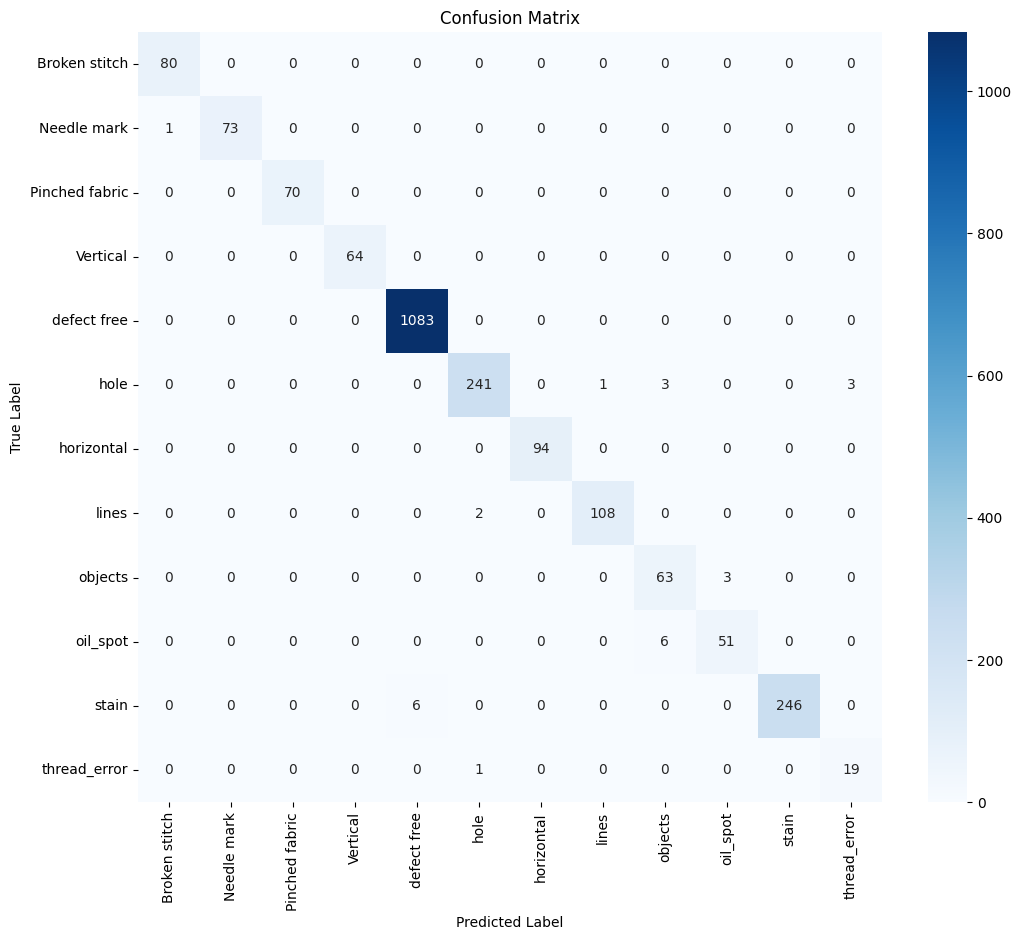

In [46]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Step 1: Predict
y_pred_probs = model.predict(test_gen, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

# Step 2: True labels
y_true = test_gen.classes

# Step 3: Get consistent class names and sort
class_indices = test_gen.class_indices
class_names = [name for name, index in sorted(class_indices.items(), key=lambda item: item[1])]
unique_labels = sorted(np.unique(y_true))

# Step 4: Classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, labels=unique_labels,
                            target_names=[class_names[i] for i in unique_labels]))

# Step 5: Confusion matrix
cm = confusion_matrix(y_true, y_pred)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[class_names[i] for i in unique_labels],
            yticklabels=[class_names[i] for i in unique_labels])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [48]:
y_pred_probs = model.predict(test_gen, verbose=1)  # shape: (n_samples, n_classes)
y_true = test_gen.classes                          # shape: (n_samples,)
class_names = list(test_gen.class_indices.keys()) # list of class names


70/70 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step


C:\Users\raman\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_ranking.py:1201: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\Users\raman\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_ranking.py:1201: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\Users\raman\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_ranking.py:1201: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\Users\raman\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_ranking.py:1201: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


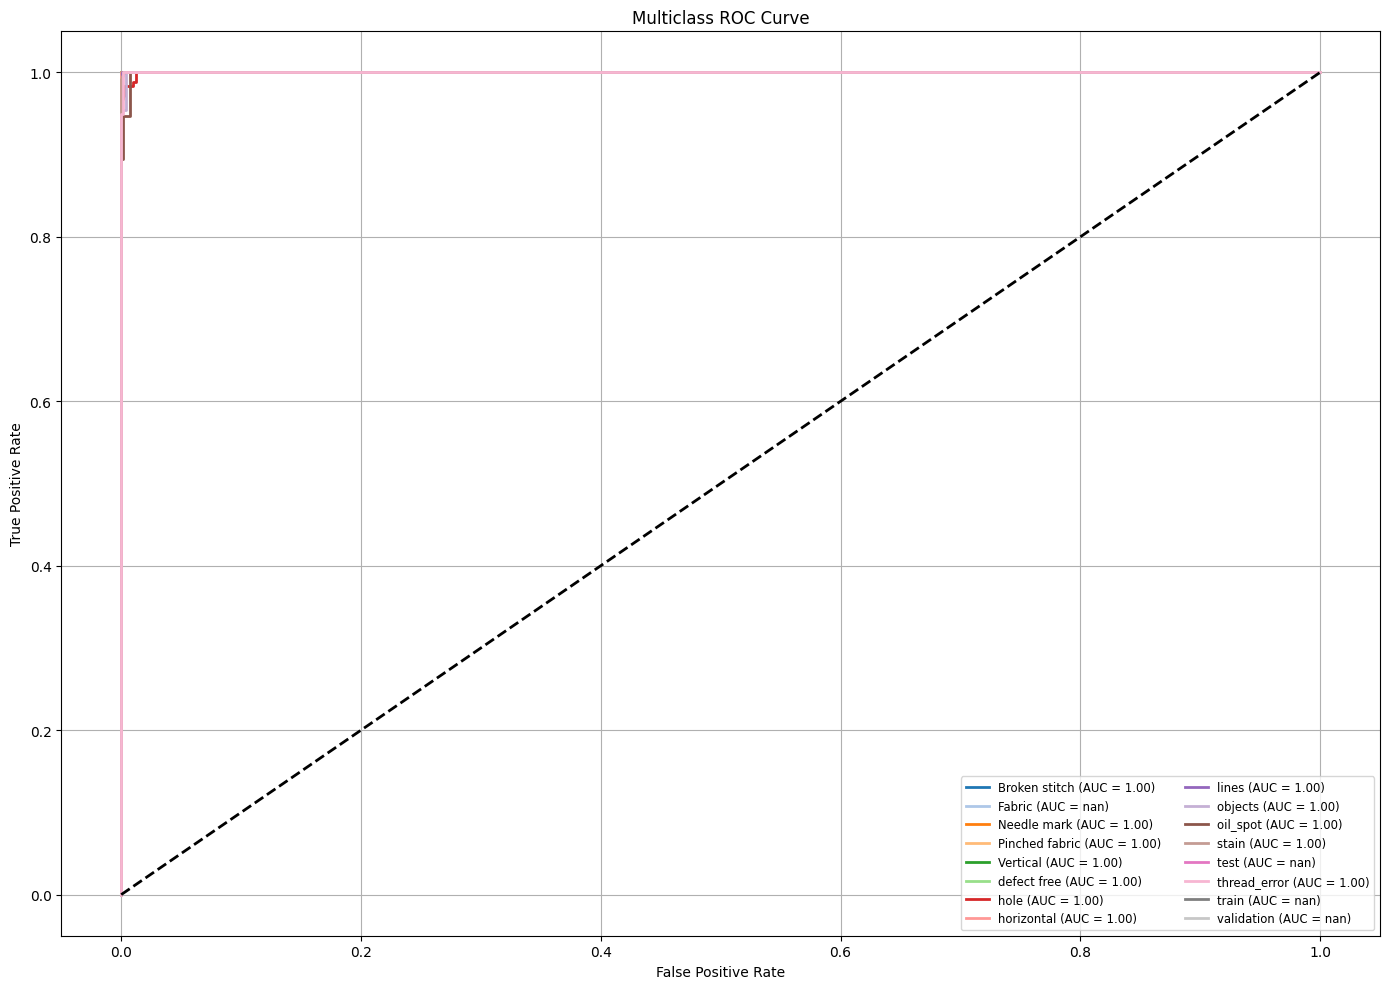

In [50]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle
import matplotlib.pyplot as plt
import numpy as np

# Binarize the output (for multi-class ROC)
y_true_bin = label_binarize(y_true, classes=list(range(len(class_names))))
n_classes = y_true_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_pred_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves
plt.figure(figsize=(14, 10))
colors = cycle(plt.cm.tab20.colors)

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{class_names[i]} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc='lower right', fontsize='small', ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()


In [56]:
# Save final model
model.save("final_fabric_model.h5")
print("\n✅ Model training complete and saved as final_fabric_model.h5")



✅ Model training complete and saved as final_fabric_model.h5
